<a href="https://colab.research.google.com/github/rashmi05pathak/CS6910_Assignment1/blob/main/EE20S051_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 181 kB 32.1 MB/s 
     |████████████████████████████████| 144 kB 44.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=38e72494b55a3e42e2347efe3b548bb66f97517e368e550210bd19d046b950cf
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [3]:
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import cv2
import wandb
import matplotlib.image as mpimg

In [4]:
%%capture
!curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > nature_12K.zip
!unzip nature_12K.zip

train_dir='inaturalist_12K/train/'
test_dir='inaturalist_12K/val/'
categories=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

In [16]:
!curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > nature_12K.zip
!unzip nature_12K.zip

train_dir='inaturalist_12K/train/'
test_dir='inaturalist_12K/val/'
categories=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/b13497d3a338d8a04c95c88b1f09c8aa.jpg  
  inflating: inaturalist_12K/train/Arachnida/f3b8c7dd76d9b492c12487a6cb29c561.jpg  
  inflating: inaturalist_12K/train/Arachnida/228cb86979512812bb38bbabf9859434.jpg  
  inflating: inaturalist_12K/train/Arachnida/ef19f8c85b8847703d00de71d49ce5ee.jpg  
  inflating: inaturalist_12K/train/Arachnida/83150d67750a7103cabeeeafddc569d0.jpg  
  inflating: inaturalist_12K/train/Arachnida/6ed7ee4ec2eb6b045c4c77cd7d01a42a.jpg  
  inflating: inaturalist_12K/train/Arachnida/e9a2a35625aac55c894e2bf8a568b2ad.jpg  
  inflating: inaturalist_12K/train/Arachnida/4a654af7bca2f2da13fbbc507f68b952.jpg  
  inflating: inaturalist_12K/train/Arachnida/2d0a609aad7a859b402cb283a48490c4.jpg  
  inflating: inaturalist_12K/train/Arachnida/ab09804cf7219c48fe96f74fceedc790.jpg  
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_

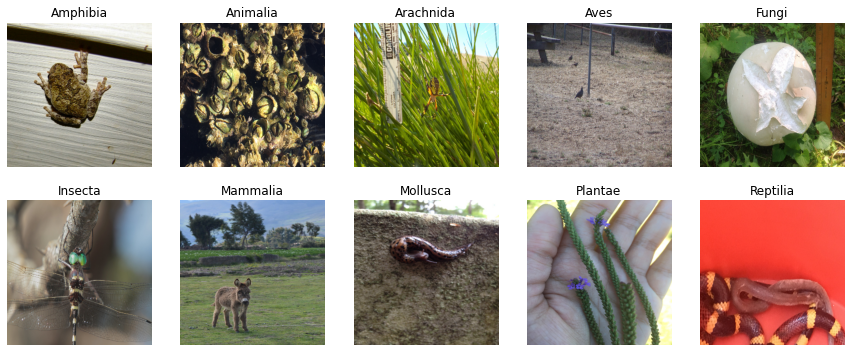

In [5]:
#visualizing images 
fig = plt.figure(figsize=(15,6))
rows,columns=2,5
i=1
for category in categories:
  dir=os.path.join(train_dir,category)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(300,300))
    fig.add_subplot(rows,columns,i)
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(category)
    i+=1   
    break
  

In [6]:
sweep_config = {
  'name': 'sweep1',  
  'method': 'grid',
  'parameters': {
        
        'filters': {
            'values': ['inc_dec','dec_inc','all_64','all_32','inc','dec']
        },
        'fc_size':{
            'values':[128]
        },
        'batchnorm':{
            'values':['yes']
        },
        'augmentation':{
            'values':['yes','No']   
        },
        'droprate':{
            'values':[0.4,0.5]
        }
           
    }

}

config_defaults={
    'filters':'inc',
    'fc_size':256,
    'batchnorm':'yes',
    'augmentation':'no',
    'droprate':0.3
}

In [7]:
def Train_CNN():

  wandb.init(config=config_defaults)
  configs=wandb.config

  configs=config_defaults

  batchnorm=configs['batchnorm']
  droprate=configs['droprate']
  augmentation=configs['augmentation']
  filter_=configs['filters']
  fc_size=configs['fc_size']

  wandb.run.name='filters_'+filter_+'_fc_size_'+str(fc_size)+'_droprate_'+str(droprate)+ str('_bn_' if batchnorm=='yes' else '') +str('augment' if augmentation=='yes' else '')

  if filter_ == 'all_64':
    filters=[64,64,64,64,64]
  elif filter_=='all_32' :
    filters=[32,32,32,32,32]
  elif filter_=='inc' :
    filters=[16,32,64,128,256]
  elif filter_ == 'dec' :
    filters=[128,64,32,16,8]
  elif filter_ =='inc_dec':
    filters=[32,64,128,64,32]
  elif filter_ =='dec_inc' :
    filters=[128,64,32,64,128]


  img_height,img_width=300,300

  model=models.Sequential()

  model.add(Conv2D(filters[0], (3, 3),input_shape=(img_height,img_width,3),activation='relu'))    
  if batchnorm =='yes':
    model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(filters[1], (3, 3),activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(filters[2], (3, 3),activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(filters[3], (3, 3),activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(filters[4], (3, 3),activation='relu'))
  if batchnorm =='yes':
    model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(fc_size,activation='relu')) 
  if batchnorm =='yes':
    model.add(BatchNormalization())
  model.add(Dropout(droprate))

  model.add(Dense(10,activation='softmax'))

  #data generators for train(with and without augmentation) and validation set
  augment= ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1.0 / 255,
    validation_split=0.1,
  )

  datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.1,
  )

  train_set = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse',
    shuffle=True,
    subset='training',
    seed=123,
  )

  aug_set = augment.flow_from_directory(
      train_dir,
      target_size=(img_height, img_width),
      batch_size=32,
      color_mode='rgb',
      class_mode='sparse',
      shuffle=True,
      subset='training',
      seed=123,
  )

  val_set = datagen.flow_from_directory(
      train_dir,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      shuffle=True,
      subset='validation',
      seed=123,
  )

  model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=[tf.keras.losses.SparseCategoricalCrossentropy()],
    metrics=['accuracy'],
  )

  if augmentation =='no' :
    hist=model.fit(train_set,epochs=10,validation_data=val_set,callbacks=[WandbCallback()])
    #hist=model.fit(train_set,epochs=10,validation_data=val_set)

  else:
    hist=model.fit(aug_set,epochs=10,validation_data=val_set,callbacks=[WandbCallback()])
    #hist=model.fit(aug_set,epochs=10,validation_data=val_set)
  
  val_acc=max(hist.history['val_accuracy'])
  params={'batch_norm':batchnorm,'augmentation':augmentation,'dropout':droprate,'filter_architecture':filter_,'val_acc':val_acc}
  wandb.log(params)

In [ ]:
#Ignore this 
sweep_id=wandb.sweep(sweep_config,entity='rashmi05pathak',project='assignment_2')
wandb.agent(sweep_id, Train_CNN)         

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: unye5law
Sweep URL: https://wandb.ai/rashmi05pathak/assignment_2/sweeps/unye5law


wandb: Agent Starting Run: evod6yt7 with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	fc_size: 128
wandb: 	filters: inc_dec
wandb: Currently logged in as: rashmi05pathak (use `wandb login --relogin` to force relogin)


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 173s 570ms/step - loss: 2.4317 - accuracy: 0.2046 - val_loss: 3.4104 - val_accuracy: 0.1011 - _timestamp: 1649243907.0000 - _runtime: 187.0000
Epoch 2/10
282/282 [==============================] - 150s 532ms/step - loss: 2.1642 - accuracy: 0.2626 - val_loss: 2.1361 - val_accuracy: 0.2663 - _timestamp: 1649244057.0000 - _runtime: 337.0000
Epoch 3/10
282/282 [==============================] - 150s 531ms/step - loss: 2.0381 - accuracy: 0.2907 - val_loss: 2.0359 - val_accuracy: 0.3123 - _timestamp: 1649244207.0000 - _runtime: 487.0000
Epoch 4/10
282/282 [==============================] - 149s 530ms/step - loss: 1.9213 - accuracy: 0.3312 - val_loss: 1.9480 - val_accuracy: 0.3173 - _timestamp: 1649244357.0000 - _runtime: 637.0000
Epoch 5/10
282/282 [==============================] - 149s 528ms/step - loss: 1.8283

accuracy,▁▂▃▃▄▄▅▆▇█
dropout,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▅▄▄▃▂▁
val_acc,▁
val_accuracy,▁▆▇▇▆▇██▇█
val_loss,█▂▁▁▂▂▁▁▂▃
accuracy,0.596
augmentation,no
batch_norm,yes
best_epoch,3


wandb: Agent Starting Run: c7s43zz3 with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	fc_size: 128
wandb: 	filters: dec_inc


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 152s 534ms/step - loss: 2.3715 - accuracy: 0.2166 - val_loss: 2.5662 - val_accuracy: 0.1602 - _timestamp: 1649245433.0000 - _runtime: 163.0000
Epoch 2/10
282/282 [==============================] - 150s 532ms/step - loss: 2.1348 - accuracy: 0.2759 - val_loss: 2.6525 - val_accuracy: 0.1762 - _timestamp: 1649245583.0000 - _runtime: 313.0000
Epoch 3/10
282/282 [==============================] - 149s 530ms/step - loss: 2.0150 - accuracy: 0.3083 - val_loss: 2.4288 - val_accuracy: 0.2032 - _timestamp: 1649245732.0000 - _runtime: 462.0000
Epoch 4/10
282/282 [==============================] - 148s 526ms/step - loss: 1.9300 - accuracy: 0.3334 - val_loss: 2.0527 - val_accuracy: 0.2963 - _timestamp: 1649245881.0000 - _runtime: 611.0000
Epoch 5/10
282/282 [==============================] - 149s 529ms/step - loss: 1.8181

accuracy,▁▂▃▃▄▄▅▆▇█
dropout,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▅▄▄▃▂▁
val_acc,▁
val_accuracy,▁▂▃▆▃█▇███
val_loss,▇█▆▂▆▁▂▂▃▃
accuracy,0.59722
augmentation,no
batch_norm,yes
best_epoch,5


wandb: Agent Starting Run: 0bhwvqjb with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	fc_size: 128
wandb: 	filters: all_64


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 146s 512ms/step - loss: 2.3762 - accuracy: 0.2148 - val_loss: 2.7453 - val_accuracy: 0.1021 - _timestamp: 1649246994.0000 - _runtime: 157.0000
Epoch 2/10
282/282 [==============================] - 143s 506ms/step - loss: 2.1533 - accuracy: 0.2648 - val_loss: 2.1485 - val_accuracy: 0.2322 - _timestamp: 1649247137.0000 - _runtime: 300.0000
Epoch 3/10
282/282 [==============================] - 141s 498ms/step - loss: 2.0232 - accuracy: 0.2963 - val_loss: 2.0696 - val_accuracy: 0.2773 - _timestamp: 1649247277.0000 - _runtime: 440.0000
Epoch 4/10
282/282 [==============================] - 141s 499ms/step - loss: 1.9190 - accuracy: 0.3338 - val_loss: 2.0295 - val_accuracy: 0.3083 - _timestamp: 1649247418.0000 - _runtime: 581.0000
Epoch 5/10
282/282 [==============================] - 143s 506ms/step - loss: 1.8096

accuracy,▁▂▂▃▄▄▅▆▇█
dropout,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▅▄▄▃▂▁
val_acc,▁
val_accuracy,▁▅▆▇▆▇█▇██
val_loss,█▃▂▂▂▁▁▃▂▂
accuracy,0.59667
augmentation,no
batch_norm,yes
best_epoch,5


wandb: Agent Starting Run: ahf53lrs with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	fc_size: 128
wandb: 	filters: all_32


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 142s 499ms/step - loss: 2.3518 - accuracy: 0.2217 - val_loss: 2.7129 - val_accuracy: 0.1602 - _timestamp: 1649248510.0000 - _runtime: 151.0000
Epoch 2/10
282/282 [==============================] - 139s 494ms/step - loss: 2.1260 - accuracy: 0.2771 - val_loss: 2.1291 - val_accuracy: 0.2723 - _timestamp: 1649248650.0000 - _runtime: 291.0000
Epoch 3/10
282/282 [==============================] - 139s 492ms/step - loss: 2.0008 - accuracy: 0.3074 - val_loss: 2.3072 - val_accuracy: 0.2262 - _timestamp: 1649248789.0000 - _runtime: 430.0000
Epoch 4/10
282/282 [==============================] - 140s 497ms/step - loss: 1.9120 - accuracy: 0.3331 - val_loss: 2.0617 - val_accuracy: 0.2773 - _timestamp: 1649248929.0000 - _runtime: 570.0000
Epoch 5/10
282/282 [==============================] - 140s 495ms/step - loss: 1.8036

accuracy,▁▂▃▃▄▄▅▆▇█
dropout,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▅▄▄▃▂▁
val_acc,▁
val_accuracy,▁▅▃▅▂▅▆█▆▆
val_loss,█▃▄▂▇▃▂▁▄█
accuracy,0.60967
augmentation,no
batch_norm,yes
best_epoch,7


wandb: Agent Starting Run: ubfd3fyw with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	fc_size: 128
wandb: 	filters: inc


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 141s 495ms/step - loss: 2.3954 - accuracy: 0.2140 - val_loss: 2.8316 - val_accuracy: 0.1191 - _timestamp: 1649249925.0000 - _runtime: 151.0000
Epoch 2/10
282/282 [==============================] - 138s 489ms/step - loss: 2.1344 - accuracy: 0.2712 - val_loss: 2.0595 - val_accuracy: 0.2823 - _timestamp: 1649250063.0000 - _runtime: 289.0000
Epoch 3/10
282/282 [==============================] - 140s 495ms/step - loss: 2.0106 - accuracy: 0.3078 - val_loss: 2.1016 - val_accuracy: 0.2883 - _timestamp: 1649250203.0000 - _runtime: 429.0000
Epoch 4/10
282/282 [==============================] - 143s 506ms/step - loss: 1.9289 - accuracy: 0.3179 - val_loss: 3.3327 - val_accuracy: 0.2192 - _timestamp: 1649250346.0000 - _runtime: 572.0000
Epoch 5/10
282/282 [==============================] - 141s 500ms/step - loss: 1.8713

accuracy,▁▂▃▃▄▅▅▆▇█
dropout,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▆▅▅▄▃▃▂▁
val_acc,▁
val_accuracy,▁▆▆▄▅▇█▇▇▆
val_loss,▆▂▂█▄▁▁▃▁▃
accuracy,0.54933
augmentation,no
batch_norm,yes
best_epoch,6


wandb: Agent Starting Run: 2g9j5o6f with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	fc_size: 128
wandb: 	filters: dec


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 143s 502ms/step - loss: 2.3913 - accuracy: 0.2123 - val_loss: 2.7601 - val_accuracy: 0.1171 - _timestamp: 1649251349.0000 - _runtime: 152.0000
Epoch 2/10
282/282 [==============================] - 144s 511ms/step - loss: 2.1443 - accuracy: 0.2694 - val_loss: 2.1446 - val_accuracy: 0.2392 - _timestamp: 1649251494.0000 - _runtime: 297.0000
Epoch 3/10
282/282 [==============================] - 143s 508ms/step - loss: 2.0057 - accuracy: 0.3061 - val_loss: 2.2270 - val_accuracy: 0.2743 - _timestamp: 1649251637.0000 - _runtime: 440.0000
Epoch 4/10
282/282 [==============================] - 141s 501ms/step - loss: 1.9027 - accuracy: 0.3359 - val_loss: 1.9898 - val_accuracy: 0.3183 - _timestamp: 1649251778.0000 - _runtime: 581.0000
Epoch 5/10
282/282 [==============================] - 141s 501ms/step - loss: 1.8127

accuracy,▁▂▃▃▄▅▆▆▇█
dropout,▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▆▅▄▄▃▂▂▁
val_acc,▁
val_accuracy,▁▅▆▇██▄▆█▆
val_loss,█▃▃▂▁▁██▃▃
accuracy,0.56978
augmentation,no
batch_norm,yes
best_epoch,4


wandb: Agent Starting Run: p034be9i with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.5
wandb: 	fc_size: 128
wandb: 	filters: inc_dec


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 141s 496ms/step - loss: 2.4063 - accuracy: 0.2117 - val_loss: 2.7614 - val_accuracy: 0.0971 - _timestamp: 1649252781.0000 - _runtime: 151.0000
Epoch 2/10
282/282 [==============================] - 138s 490ms/step - loss: 2.1676 - accuracy: 0.2649 - val_loss: 2.2405 - val_accuracy: 0.2172 - _timestamp: 1649252919.0000 - _runtime: 289.0000
Epoch 3/10
282/282 [==============================] - ETA: 0s - loss: 2.0103 - accuracy: 0.3043

In [10]:
#Trail run 
Train_CNN()

AttributeError: ignored

In [ ]:
#train model with best configs
model=models.Sequential()

img_height,img_width=300,300

model.add(Conv2D(16,(3, 3),input_shape=(img_height,img_width,3),activation='relu'))    
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
batch_normalization_21 (Batc (None, 298, 298, 16)      64        
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 35, 35, 64)       

In [ ]:
#data generators for train and validation set
augment= ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1.0 / 255,
    validation_split=0.1
)

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.1
)

train_set = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse',
    shuffle=True,
    subset='training',
    seed=123,
)

aug_set = augment.flow_from_directory(
      train_dir,
      target_size=(img_height, img_width),
      batch_size=32,
      color_mode='rgb',
      class_mode='sparse',
      shuffle=True,
      subset='training',
      seed=123,
)

val_set = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    class_mode='sparse',
    shuffle=True,
    subset='validation',
    seed=123,
)


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=[tf.keras.losses.SparseCategoricalCrossentropy()],
    metrics=['accuracy'],
  )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,restore_best_weights=True)

model.fit(train_set,epochs=10,validation_data=val_set,callbacks=[early_stop])

Epoch 1/10
282/282 [==============================] - 117s 411ms/step - loss: 2.6400 - accuracy: 0.1757 - val_loss: 2.6895 - val_accuracy: 0.1431
Epoch 2/10
282/282 [==============================] - 116s 410ms/step - loss: 2.1463 - accuracy: 0.2571 - val_loss: 2.2300 - val_accuracy: 0.1972
Epoch 3/10
282/282 [==============================] - 116s 412ms/step - loss: 1.9959 - accuracy: 0.3061 - val_loss: 2.3174 - val_accuracy: 0.2683
Epoch 4/10
282/282 [==============================] - 117s 415ms/step - loss: 1.8892 - accuracy: 0.3317 - val_loss: 2.0116 - val_accuracy: 0.3003
Epoch 5/10
282/282 [==============================] - 116s 413ms/step - loss: 1.8134 - accuracy: 0.3712 - val_loss: 1.9589 - val_accuracy: 0.3433
Epoch 6/10
282/282 [==============================] - 118s 417ms/step - loss: 1.7142 - accuracy: 0.3951 - val_loss: 2.1914 - val_accuracy: 0.2833
Epoch 7/10
282/282 [==============================] - 118s 417ms/step - loss: 1.5790 - accuracy: 0.4452 - val_loss: 1.9407 -

In [ ]:
#data generator for test set
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
  )

test_set = test_datagen.flow_from_directory(
      test_dir,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      shuffle=True,
      seed=123,
  )

#evaluating model on test set
model.evaluate(test_set)

Found 2000 images belonging to 10 classes.
63/63 [==============================] - 22s 353ms/step - loss: 1.9224 - accuracy: 0.3700


[1.922382116317749, 0.3700000047683716]

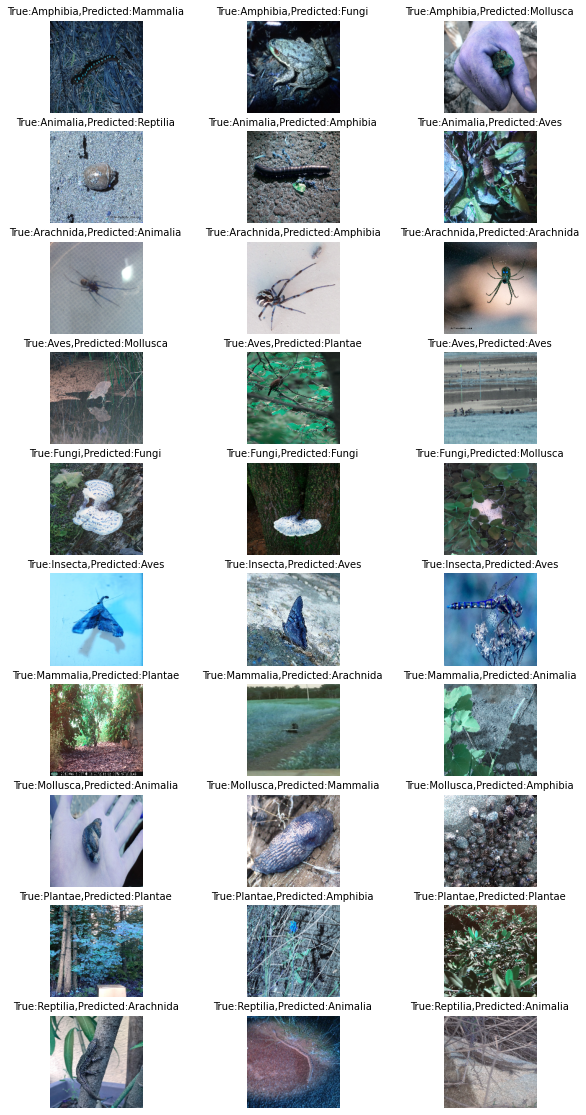

In [ ]:
#taking 30 sample images,3 from each class for visualizing

x,y,y_pred=[],[],[]
for category in categories:
    i=0
    path=os.path.join(test_dir,category)
    for img in os.listdir(path):
      if i==3:
        break
      try:
        image = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
        x.append(image)
        y.append(category)
        pic = cv2.resize(image, (300,300)) / 255.0
        prediction = model.predict(pic.reshape(1,300, 300,3))
        c=prediction.argmax()
        y_pred.append(categories[c])
        i+=1
      except:
        break

#plotting a 10x3 grid with predictions
fig = plt.figure(figsize=(10,20))
rows,columns=10,3
i=1
for k in range(30):

  img=cv2.resize(x[k],(150,150))
  fig.add_subplot(rows,columns,i)
  plt.imshow(img)
  plt.axis('off')
  plt.title('True:'+y[k]+',Predicted:'+y_pred[k],fontdict={'fontsize':10})
  i+=1   
wandb.init(entity='sanjeev-nimeesh',project='assignment_2')
wandb.log({'predicting on sample images':plt}) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


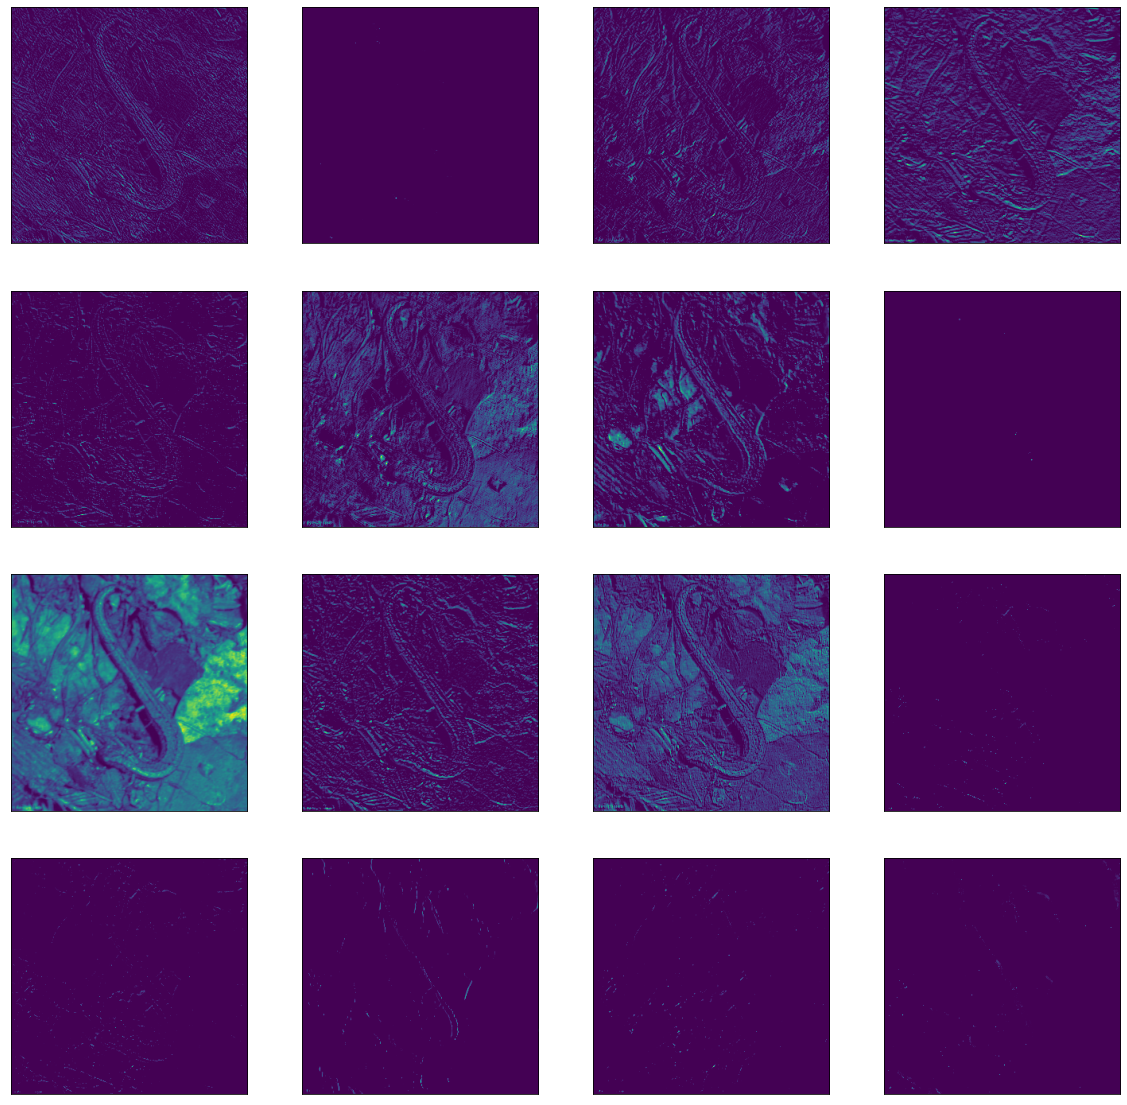

In [ ]:
#visualizing filters

def fil_vis(lay='conv2d_35'):              #name of 1st conv layer
  fil_model = tf.keras.models.Model(
      inputs = [model.inputs],    
      outputs = [model.get_layer(lay).output]
  )
  category = categories[0]
  dir=os.path.join(test_dir,category)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=cv2.imread(img_path)
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(300,300))
    x = np.expand_dims(new_img, axis=0) 
    inputs = tf.cast(x, tf.float32)
    out = fil_model(inputs)[0]

      
  
    #f_min, f_max = out.min(), out.max()
    #filters = (out - f_min) / (f_max - f_min)
    # plot first few filters
    n_filters, ix = 16, 1
    plt.figure(figsize=(20,20))
    for i in range(n_filters):
      # get the filter
      f = out[:, :, i]
      # plot each channel separately
      for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(4, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f)
      ix += 1
    # show the figure
    plt.show()
    break

fil_vis()